In [2]:
from typing import List, Dict, Any, Tuple, Optional, Self

import math, random, dataclasses, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.axes
from matplotlib.cm import get_cmap

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Structures de données et Visualisation

In [3]:
@dataclasses.dataclass
class Probleme:
    n: int  # Nombre de clients
    m: int  # Nombre de véhicules
    L: float  # Budget temps
    points: pd.DataFrame  # DataFrame des clients (x, y, score) => Pas une vraie donnée du problème TOP, mais utile pour afficher sur la carte
    # index du point de départ et du point d'arrivée (par défaut 0 et 1)
    start: int = 0
    end: int = 1
    # distance matrix stored as a numpy ndarray (shape n x n)
    dist_matrix: np.ndarray = dataclasses.field(init=False, repr=False)

    @classmethod
    def from_file(cls, filepath: str, start: int = 0, end: int = 1) -> Self:
        """Charge une instance à partir d'un fichier TSV attendu:\n première ligne: L <tab> m \n les lignes suivantes: x <tab> y <tab> score
        On peut passer `start` et `end` pour indiquer les indices des points de départ/arrivée dans les données.
        """
        metadata = pd.read_csv(filepath, sep='\t', nrows=1, header=None)
        points = pd.read_csv(filepath, sep='\t', skiprows=1, header=None)
        df = points.astype({0: float, 1: float, 2: int}).rename(columns={0: "x", 1: "y", 2: "score"})
        df = df.reset_index().rename(columns={'index': 'id'})
        return cls(
            n=df.shape[0],
            L=float(metadata.iloc[0, 0]),  # type: ignore
            m=int(metadata.iloc[0, 1]),  # type: ignore
            points=df,
            start=start,
            end=end,
        )

    def __post_init__(self):
        # compute Euclidean distances between points and store as numpy ndarray (shape n x n)
        pts = self.points[['x', 'y']].to_numpy()  # positional array, id == row index
        diffs = pts[:, None, :] - pts[None, :, :]
        mat = np.linalg.norm(diffs, axis=2)
        self.dist_matrix = mat  # numpy ndarray
        # Valider que start et end sont des indices valides [0, n-1]
        if not (0 <= self.start < self.n) or not (0 <= self.end < self.n):
            raise ValueError(f"Start ({self.start}) et End ({self.end}) doivent être des indices valides entre 0 et n-1")

    def scores_dict(self) -> Dict[int, int]:
        """Retourne un dict id -> score (utilise la colonne 'id' pour correspondre aux entiers)."""
        ids = self.ids()
        scores = self.points['score'].astype(int).tolist()
        return dict(zip(ids, scores))

    def ids(self) -> List[int]:
        return list(range(self.n))

    def plot(self, ax=None, title: Optional[str] = None) -> matplotlib.axes.Axes:
        """Affiche les points du problème sur `ax` (ou crée une figure).\n"""
        if ax is None:
            fig, ax = plt.subplots()
        pts = self.points
        ax.scatter(pts['x'], pts['y'], c='tab:blue', s=40, label='clients')
        # Annotate id and score next to chaque point
        for _, row in pts.iterrows():
            ax.text(row['x'] + 0.02, row['y'] + 0.02, f'id={int(row['id'])}, s={int(row['score'])}', fontsize=9)
        ax.set_title(title if title is not None else 'Instance')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend(loc='best')
        return ax


@dataclasses.dataclass
class Route:
    """Représente un cycle visitant une liste de points dans un problème donné et se connectant (implicitement) au point de départ à la fin."""
    stops: List[int]  # Indices (id column) des points visités en ordre
    probleme: Probleme  # Référence au problème associé pour calculer les métriques
    total_distance: float = 0.0
    total_score: int = 0

    def __post_init__(self):
        self.compute_totals()
        
    def __copy__(self) -> "Route":
        new = object.__new__(Route)  # Avoid recomputing totals
        new.stops = list(self.stops)
        new.probleme = self.probleme
        # preserve the already-computed totals without recomputing
        new.total_distance = self.total_distance
        new.total_score = self.total_score
        return new

    def compute_totals(self) -> None:
        """Calcule la distance du parcours (cycle) et le score cumulé des visites de noeuds."""
        # Use positional numpy arrays for coordinates and scores (ids are row indices)
        pts_arr = self.probleme.points[['x', 'y', 'score']].to_numpy()
        # Cas où il n'y a aucun arrêt
        if not self.stops:
            self.total_distance = 0.0
            self.total_score = 0
            return
        # Calculer les coordonnées des arrêts dans l'ordre (positional indexing)
        coords = pts_arr[self.stops, :2]
        # distances entre arrêts consécutifs
        dists = np.linalg.norm(coords[1:] - coords[:-1], axis=1) if len(coords) > 1 else np.array([], dtype=float)
        total = float(dists.sum())
        # Ajouter la distance de retour au point de départ pour former un cycle (TOP exige un retour)
        if len(coords) > 1:
            total += float(np.linalg.norm(coords[0] - coords[-1]))
        self.total_distance = total
        # score cumulé des arrêts
        self.total_score = int(pts_arr[self.stops, 2].sum())

    def __add__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route avec `other` ajouté à la fin."""
        if other in self.stops:
            raise ValueError("Stop already in route")
        new_stops = list(self.stops) + [other]
        return Route(new_stops, self.probleme)

    def __remove__(self, other: int) -> 'Route':
        """Retourne une NOUVELLE Route sans l'arrêt `other`."""
        if other not in self.stops:
            raise ValueError("Stop not in route")
        new_stops = [s for s in self.stops if s != other]
        return Route(new_stops, self.probleme)

    def plot(self, ax=None, color='tab:orange', label: Optional[str] = None) -> matplotlib.axes.Axes:
        """Dessine la route sur `ax` (crée `ax` si None)."""
        if ax is None:
            fig, ax = plt.subplots()
        if not self.stops:
            return ax
        coords = self.probleme.points[['x', 'y']].to_numpy()[self.stops]
        # pour tracer le cycle, ajouter le premier point à la fin
        if len(coords) > 1:
            closed = np.vstack([coords, coords[0]])
        else:
            closed = coords
        # plot polyline (cycle)
        ax.plot(closed[:, 0], closed[:, 1], '-o', c=color, lw=2, label=(label if label else 'route'))
        # annotate stops with order
        for idx, sid in enumerate(self.stops):
            row = self.probleme.points.iloc[sid]
            ax.text(row['x'] + 0.02, row['y'] + 0.02, str(idx), color=color, fontsize=9)  # type: ignore : types de colonnes pandas non vérifiés
        return ax

# Recherche d'une solution initiale

In [4]:
def simple_greedy_routes(prob: Probleme, seed: Optional[int] = None, snapshot_every: int = 0) -> Tuple[List[Route], List[List[Route]]]:
    """Construction gloutonne (insertion séquentielle) adaptée au TOP.
    Les routes sont initialisées comme [start, end] et on insère des clients entre des paires
    consécutives (pos, pos+1). On utilise `prob.dist_matrix` (numpy) pour calculer delta de coût.
    Retourne (routes, snapshots).
    """
    # ids is a simple numeric range; do not rely on pandas index labels
    ids = prob.ids()
    scores = prob.scores_dict()
    # On ne sert pas start/end
    unserved = set(ids) - {prob.start, prob.end}
    routes: List[Route] = [Route([prob.start, prob.end], prob) for _ in range(prob.m)]
    snapshots: List[List[Route]] = []
    inserted = 0

    # insertion: pour chaque route, pour chaque position entre stops[pos] and stops[pos+1],
    # calculer delta = dist(i,u) + dist(u,j) - dist(i,j) using numpy dist_matrix
    while True:
        best = None  # tuple (ratio, r_idx, pos, u, delta)
        for r_idx, r in enumerate(routes):
            for pos in range(len(r.stops) - 1):
                i = r.stops[pos]
                j = r.stops[pos + 1]
                for u in list(unserved):
                    dlt = float(prob.dist_matrix[i, u] + prob.dist_matrix[u, j] - prob.dist_matrix[i, j])
                    new_cost = r.total_distance + dlt
                    if new_cost <= prob.L + 1e-9:
                        ratio = scores[u] / (dlt if dlt > 1e-9 else 1e-9)
                        if best is None or ratio > best[0]:
                            best = (ratio, r_idx, pos, u, dlt)
        if best is None:
            break
        _, r_idx, pos, u, dlt = best
        # perform insertion
        new_stops = list(routes[r_idx].stops)
        new_stops.insert(pos + 1, u)
        routes[r_idx] = Route(new_stops, prob)
        unserved.remove(u)
        inserted += 1
        if snapshot_every and (inserted % snapshot_every == 0):
            snapshots.append(routes.copy())
            
    return routes, snapshots

# Amélioration d'une solution (rechrche locale)

In [5]:
def two_opt_route(route: Route, max_iter: int = 1000) -> Route:
    """Amélioration locale 2-opt sur une Route (retourne une NOUVELLE Route améliorée).
    On respecte la contrainte de longueur `route.probleme.L`: toute modification doit garder total_distance <= prob.L.
    Les extrémités (start / end) sont conservées.
    """
    best = Route(list(route.stops), route.probleme)
    n = len(best.stops)
    if n < 4:  # moins de 2 arêtes internes -> rien à inverser
        return best
    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        for i in range(1, n - 2):  # ne pas toucher l'indice 0 (start)
            for j in range(i + 1, n - 1):  # ne pas toucher l'indice n-1 (end)
                # créer une nouvelle permutation en inversant le segment i..j
                new_stops = best.stops[:i] + list(reversed(best.stops[i:j+1])) + best.stops[j+1:]
                candidate = Route(new_stops, route.probleme)
                # accepter si amélioration (réduction de distance) et toujours faisable
                if candidate.total_distance + 1e-9 < best.total_distance and candidate.total_distance <= route.probleme.L + 1e-9:
                    best = candidate
                    improved = True
                    break
            if improved:
                break
    return best

# Tests

In [7]:
import time
class Lap():
    def __init__(self):
        self.current_time = time.time()
    def lap(self) -> float:
        lap_time = time.time() - self.current_time
        self.current_time = time.time()
        return lap_time
lap = Lap()

filepath = 'data/tsiligirides_problem_1_budget_50.txt'
prob = Probleme.from_file(filepath)
print(f"Problème chargé: n={prob.n}, m={prob.m}, L={prob.L} / temps écoulé: {lap.lap():.4f}s")

routes, snapshots = simple_greedy_routes(prob, snapshot_every=5)
print(f"Routes construites: {len(routes)} / temps écoulé: {lap.lap():.4f}s")

for r_idx, r in enumerate(routes):
    improved = two_opt_route(r, max_iter=500)
    routes[r_idx] = improved
print(f"Routes améliorées avec 2-opt / temps écoulé: {lap.lap():.4f}s")

print(f"Score final des routes: {[r.total_score for r in routes]} = {sum(r.total_score for r in routes)}")
print(f"Répartition des distances: {[r.total_distance for r in routes]} = {sum(r.total_distance for r in routes)} / budget max: {prob.L * prob.m} = {prob.L} x {prob.m}")

Problème chargé: n=32, m=3, L=50.0 / temps écoulé: 0.0085s
Routes construites: 3 / temps écoulé: 0.0233s
Routes améliorées avec 2-opt / temps écoulé: 0.0800s
Score final des routes: [130, 155, 0] = 285
Répartition des distances: [47.16539881676702, 47.137995119618765, 1.5231546211727809] = 95.82654855755857 / budget max: 150.0 = 50.0 x 3


seed = 1020215239


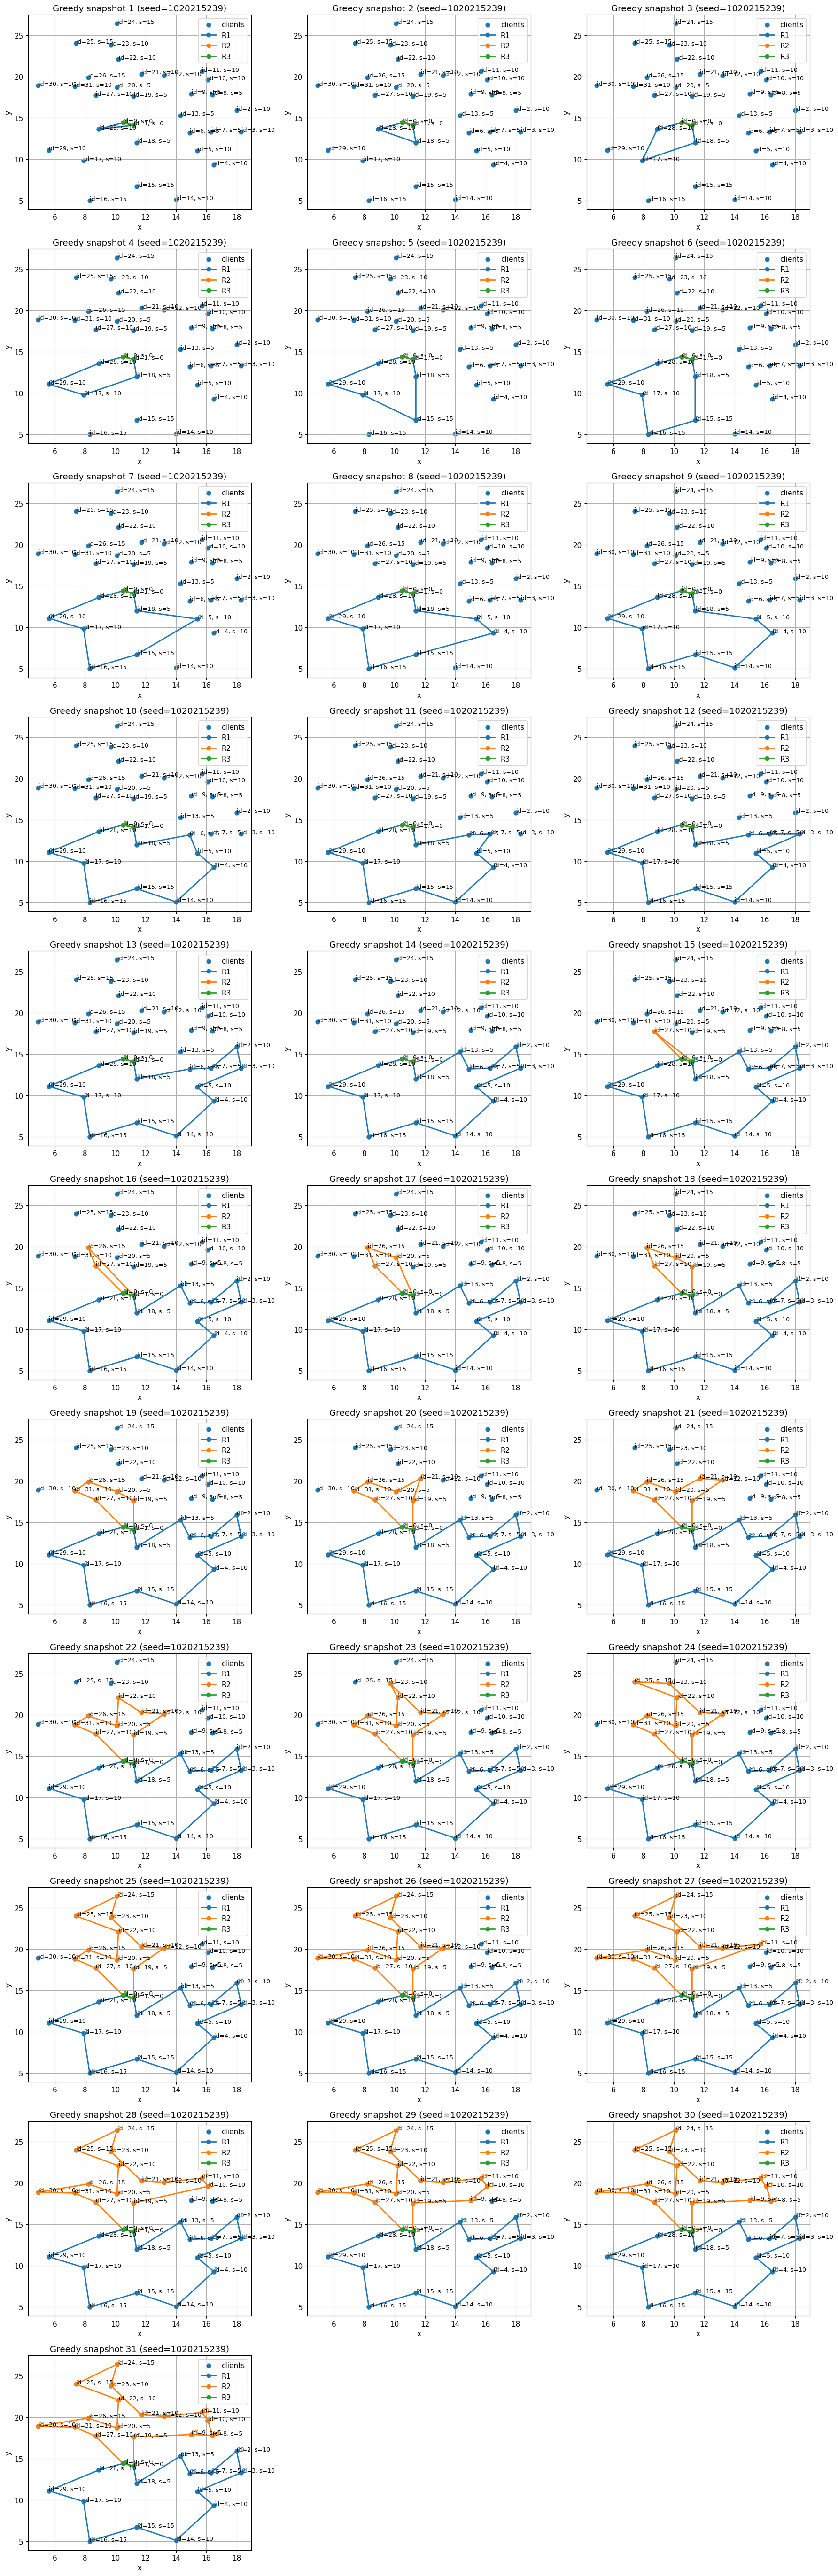

In [10]:
filepath = 'data/tsiligirides_problem_1_budget_50.txt'
prob = Probleme.from_file(filepath)

# dist_matrix est calculée automatiquement dans Probleme.__post_init__
seed = random.randrange(1 << 30)
routes, snapshots = simple_greedy_routes(prob, seed=seed, snapshot_every=1)
print('seed =', seed)

# Après construction, appliquer 2-opt sur chaque route
for i, r in enumerate(routes):
    routes[i] = two_opt_route(r)
snapshots.append(routes.copy())

# Plot snapshots in a 3 x N grid
cols = 3
n_snap = len(snapshots)
if n_snap > 0:
    rows = math.ceil(n_snap / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    # flatten axes array for easy indexing
    axs_flat = axs.flatten() if hasattr(axs, 'flatten') else [axs]
    for i, s in enumerate(snapshots):
        ax = axs_flat[i]
        prob.plot(ax=ax, title=f'Greedy snapshot {i+1} (seed={seed})')
        for j, r in enumerate(s):
            r.plot(ax=ax, color=f'C{j%10}', label=f'R{j+1}')
        ax.legend()
    # hide unused axes
    for k in range(n_snap, rows*cols):
        axs_flat[k].axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('No snapshots to display')

# Import d'un Problème

In [ ]:
        
filepath = 'data/tsiligirides_problem_1_budget_50.txt'
Probleme.from_file(filepath).points